# GDPR Fines Data Exploration

## Setup

In [1]:
import numpy as np
import pandas as pd

from scripts.wrangling_funs import filter_for_positives, strip_text_col, pivot_fines_longer

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

The data for this project is scraped from: [Privacy Affairs: GDPR Fines List](https://www.privacyaffairs.com/gdpr-fines/). The scraped data is included in `data/scraped_gdpr_fines.csv`

In [2]:
fines = pd.read_csv("data/scraped_fines.csv", parse_dates=["date"])

In [3]:
fines.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,1701.0,8.510000e+02,4.911807e+02,1.0,426.0,851.0,1276.0,1.701000e+03
price,1701.0,2.352414e+06,3.795134e+07,0.0,2000.0,6000.0,40000.0,1.200000e+09


Before performing analysis a minor amount of cleaning is required for the 'raw' data

1. remove fines with 0 price
2. remove whitespace from type column

In [4]:
fines_nozero = (
    fines
    .pipe(filter_for_positives, "price")
    .pipe(strip_text_col, "type")
)

# Questions

## Big Picture

1. How are the fine amounts distributed?
2. How does the distribution of fine amount change over time?

### How are the fines distributed?

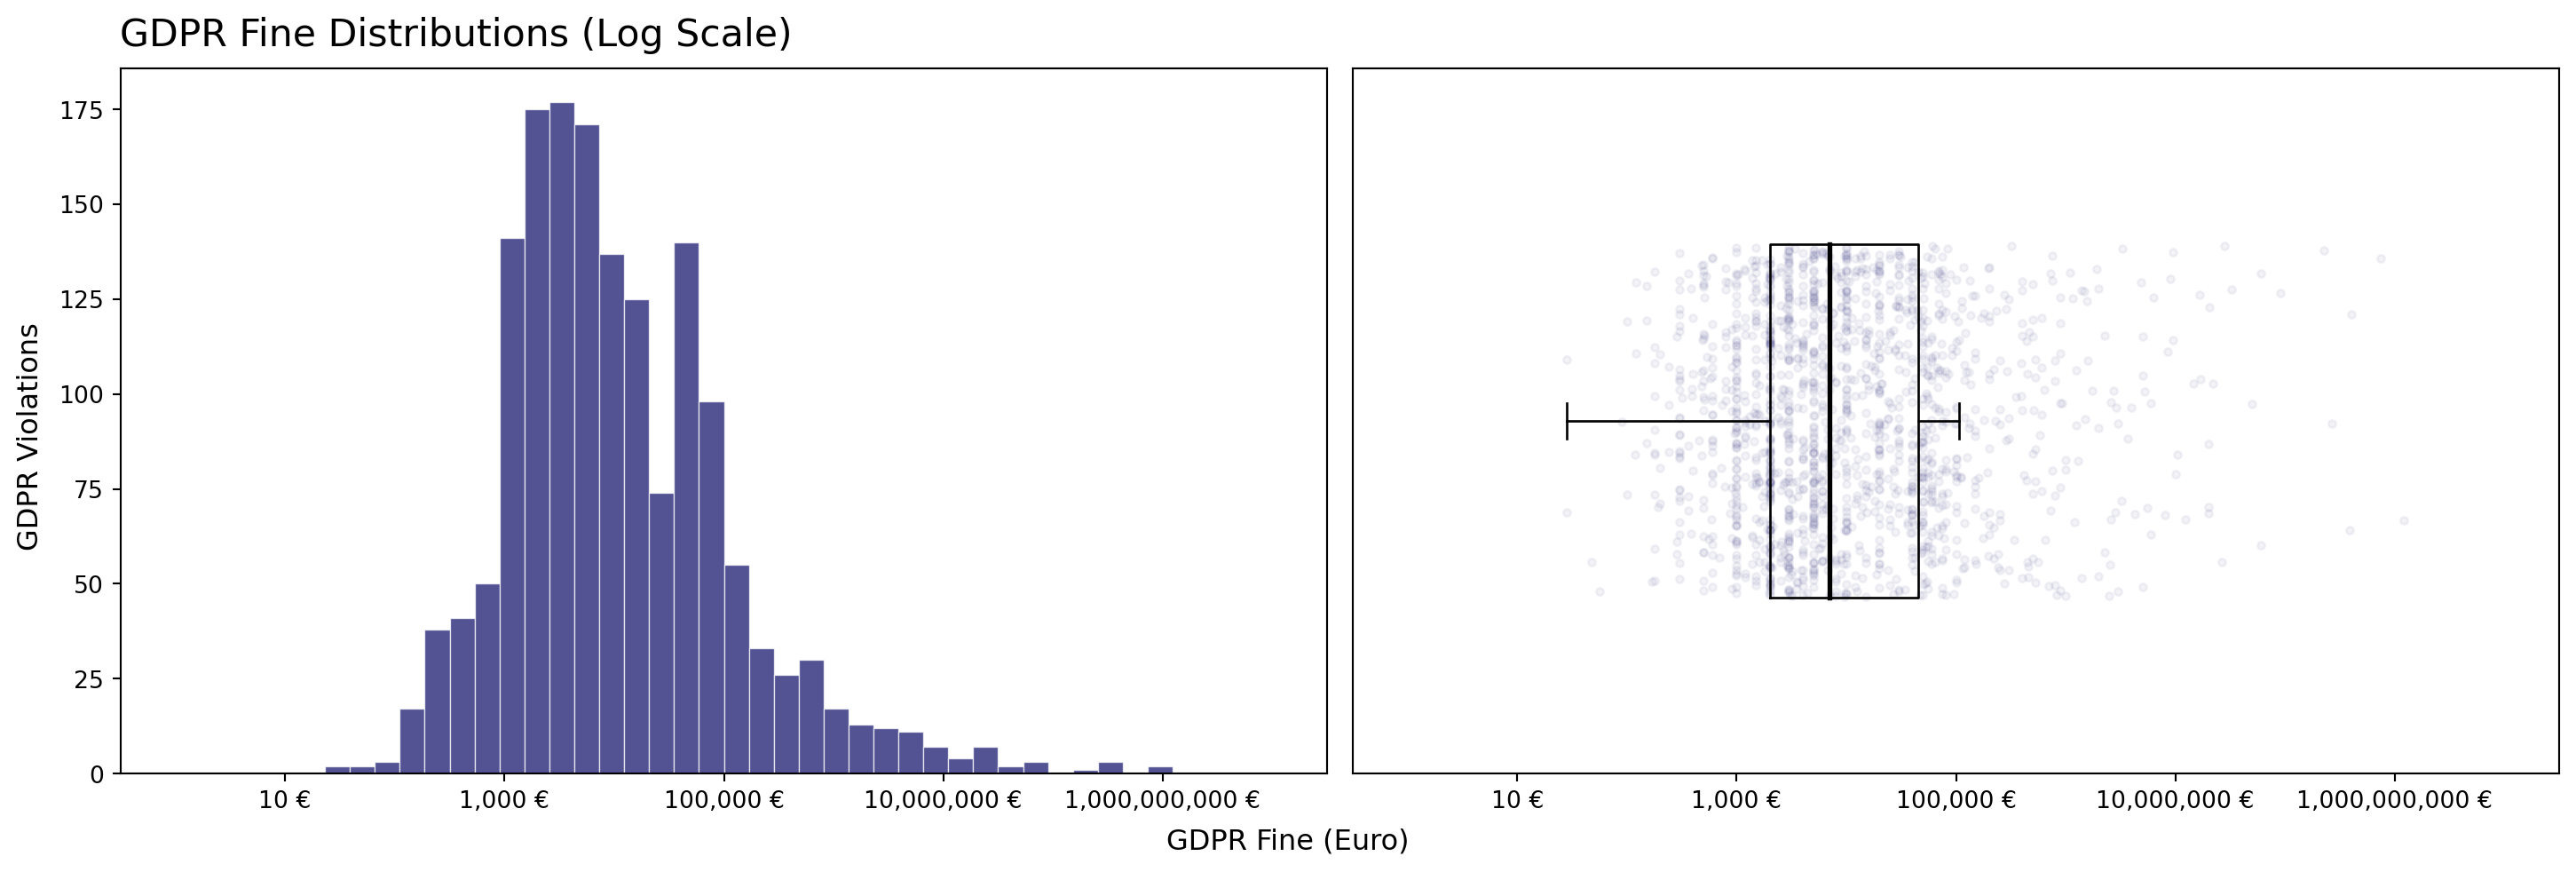

In [5]:
fig, ax = plt.subplots(1,2, figsize=(15, 5), sharex=True, layout="constrained")

sns.histplot(
    fines_nozero, x="price",
    edgecolor="white", linewidth=.5, facecolor="midnightblue",
    log_scale=True, binrange=(0, 10),
    ax=ax[0]
)

for bar in ax[0].patches:
    bar.set_alpha(0.75) 

ax[0].set(xlabel= None, ylabel=None)
ax[0].xaxis.set_major_formatter('{x:,.0f} €')

# jitter points about 1 on y axis.
ax[1].scatter("price", "y", data=fines_nozero.assign(
    y=1+np.random.uniform(low=-0.25, high=0.25, size=len(fines_nozero))),
    c='midnightblue', alpha=0.05, s=10)

box = ax[1].boxplot(
    data=fines_nozero, x="price", vert=False,
    widths=0.5,
    showfliers=False,
    medianprops={'color':'black', 'linewidth':2}
)

# smaller caps
for cap in box['caps']:
    cap.set_ydata(cap.get_ydata() - [-0.1, 0.1])

ax[1].set_xscale('log')
ax[1].set(ylabel=None)
ax[1].set_yticks([])
ax[1].set_yticklabels([])
ax[1].xaxis.set_major_formatter('{x:,.0f} €')

# draw the figure to apply constrained_layout (useful only for positioning suptitle later)

fig.supylabel(t="GDPR Violations")
fig.supxlabel(t="GDPR Fine (Euro)")

fig.canvas.draw()

fig.suptitle(
    t="GDPR Fine Distributions (Log Scale)", 
    x=ax[0].get_position().x0,
    ha='left', fontsize=16,
)

plt.show()

### How has the distribution of fines changed over time?

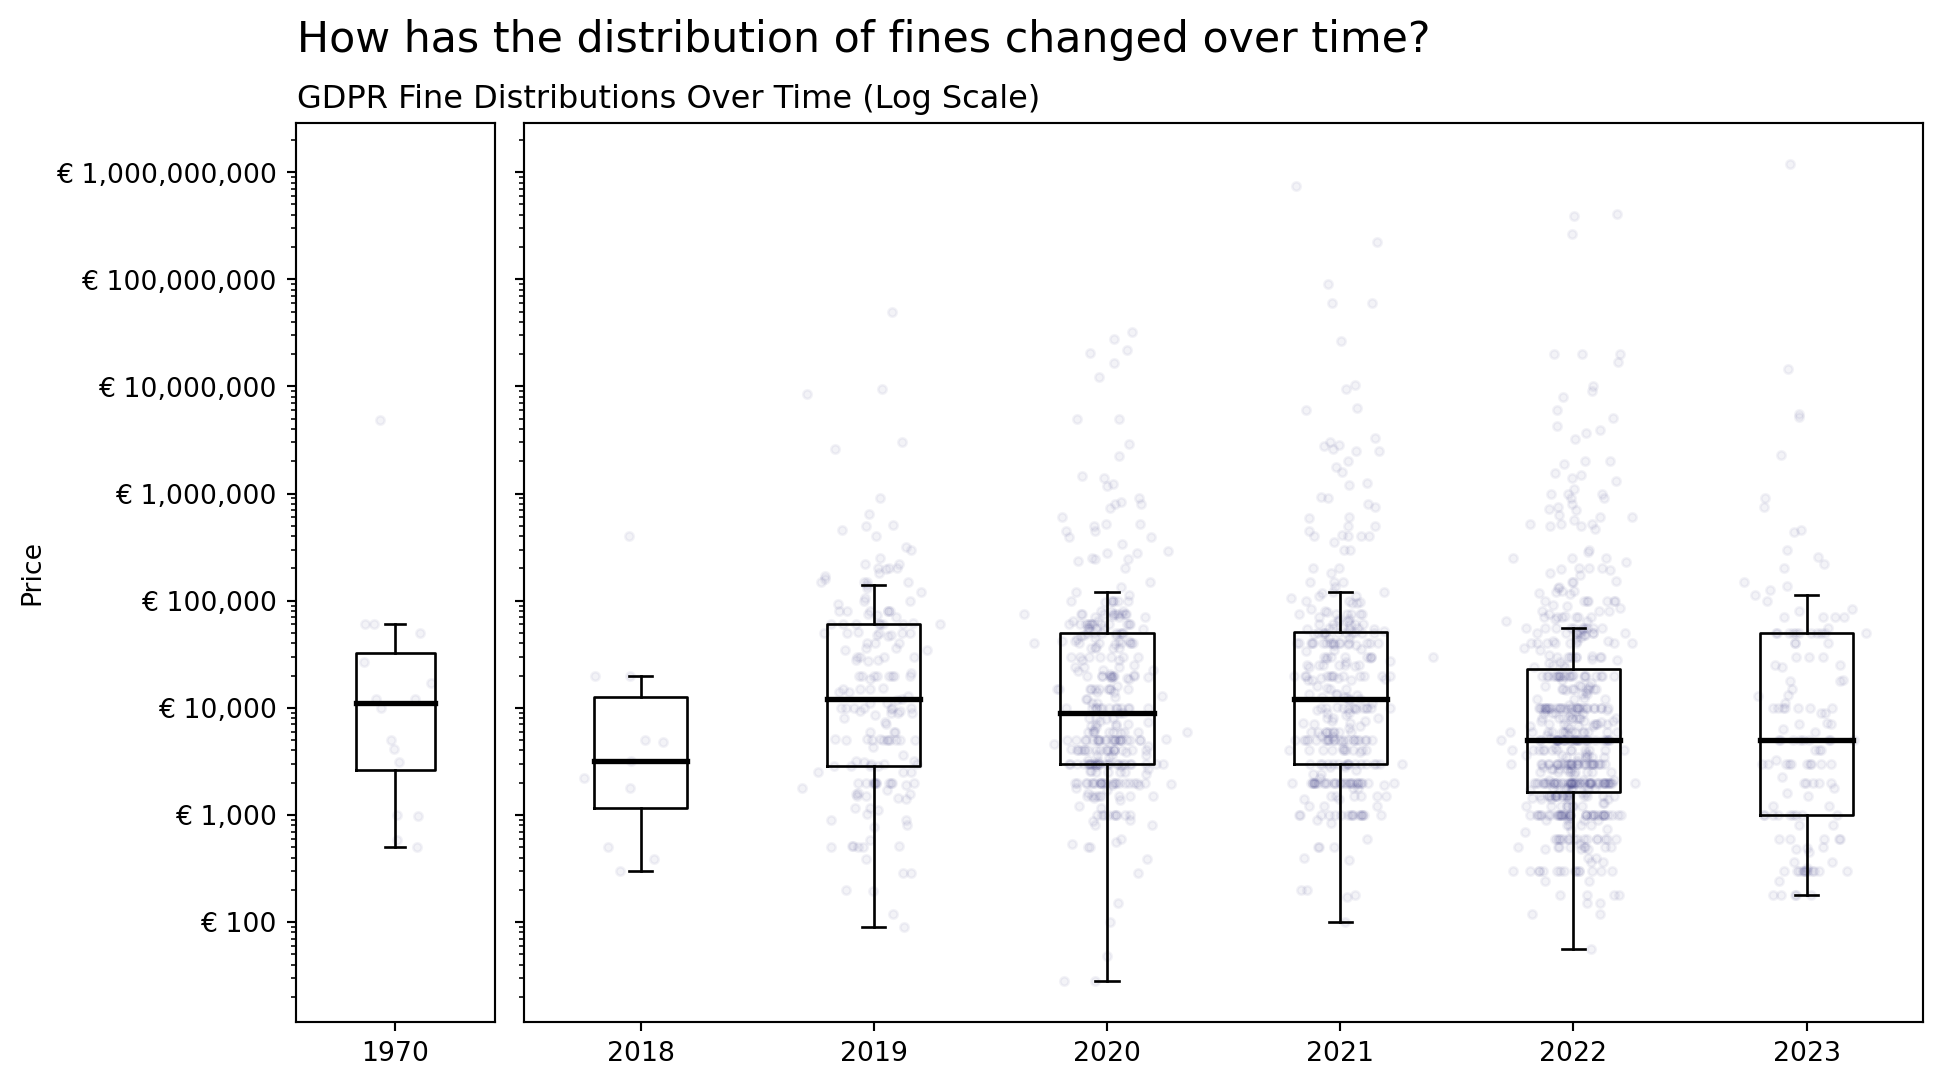

In [6]:
df = (fines_nozero.assign(
    year = lambda x: x.date.dt.year
))

# make data more friendly for matplotlib
prices_each_year = df.groupby('year')['price'].apply(lambda x: x.values)

# Get the years as labels
labels = list(prices_each_year.keys())
labels.sort()

#create a figure with subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5),
                       gridspec_kw={'width_ratios': [1, 7]},
                       sharey=True, layout='constrained')

# Create a boxplot for the year 1970
box1 = ax[0].boxplot(prices_each_year[1970], labels=['1970'], widths=0.4, showfliers=False, medianprops={'color':'black', 'linewidth':2})
ax[0].set_ylabel('Price')


# Create a boxplot for the years other than 1970
years_other_than_1970 = [year for year in labels if year != 1970]
box2 = ax[1].boxplot([prices_each_year[year] for year in years_other_than_1970],
              labels=years_other_than_1970, showfliers=False, widths=0.4,
              medianprops={'color':'black', 'linewidth':2})

# smaller caps
for box in list((box1, box2)):
    for cap in box['caps']:
        cap.set_xdata(cap.get_xdata() - [-0.05, 0.05])

ax[1].set_ylabel(None)

jittered_x = np.random.normal(0 + 1, 0.1, len(prices_each_year[1970]))
ax[0].scatter(jittered_x, prices_each_year[1970], alpha=0.05, color='midnightblue', s=10)


# Overlay the data points for the years other than 1970
for i, year in enumerate(years_other_than_1970):
    jittered_x = np.random.normal(i + 1, 0.1, len(prices_each_year[year]))
    ax[1].scatter(jittered_x, prices_each_year[year], alpha=0.05, color='midnightblue', s=10)

ax[1].set_yscale('log')
ax[1].yaxis.set_major_formatter('€ {x:,.0f}')

# draw the figure to apply constrained_layout (req for positioning suptitle)
fig.canvas.draw()

fig.suptitle(
    t="How has the distribution of fines changed over time?", 
    ha='left',
    x=ax[0].get_position().x0,
    fontsize=16,
    y=1.1,
    va='top'
)

# subtitle
plt.figtext(ax[0].get_position().x0, 1, "GDPR Fine Distributions Over Time (Log Scale)", va="bottom", ha="left", size=12)
plt.show()

## Controllers

1. Who pays the most?
2. Who pays the most often? 

Some data wrangling is required to create a summary view for each controller. Ideally for each separate controller it would be good to construct a table with:

- the controller name
- the number of times that controller has been fined
- the sum of the fines that controller has had to pay
- the mean of the fines that controller has had to pay

This is useful for direct comparison.

The large companies (e.g. Meta, Amazon) often have multiple different controller names. For simplicity in communication these have been combined (i.e. Meta/Facebook refers to any controller regarding Meta/Facebook: Meta Platforms Inc. (Facebook), Meta Platforms Ireland Limited (Facebook), etc.)


### Who pays the most?

In [7]:
def strfind(series, term):
    """"
    time-saver
    """
    return series.str.contains(term, case=False)

# Give multi-national corps standard names
# Facebook/Meta Ireland -> Facebook/Meta
fines_controller_gb = (
    fines_nozero
    .assign(
        shortname = lambda x: np.select(
            [strfind(x.controller, "Facebook"), strfind(x.controller, "Meta "), strfind(x.controller, "Amazon"),
             strfind(x.controller, "Google"), strfind(x.controller, "Microsoft"), strfind(x.controller, "Vodafone"),
             strfind(x.controller, "WhatsApp"), strfind(x.controller, "Clearview"), strfind(x.controller, "H&M"),
             strfind(x.controller, "Marriott")],
            ["Facebook/Meta", "Facebook/Meta", "Amazon",
             "Google", "Microsoft", "Vodafone",
             "WhatsApp", "Clearview AI", "H&M",
             "Marriot"],
            x.controller
        )
    )
    .assign(shortname = lambda x: x.shortname.str.title().str.strip().replace(""))
    .groupby('shortname')
)

controller_counts = fines_controller_gb.size().to_frame(name='counts')
controller_stats = (
    controller_counts
    .join(fines_controller_gb.agg({'price':'sum'}).rename(columns={'price':'total_price'}))
    .join(fines_controller_gb.agg({'price':'mean'}).rename(columns={'price':'mean_price'}))
    .reset_index()
)

controller_stats.sort_values('total_price', ascending=False).head(3)

,shortname,counts,total_price,mean_price
409,Facebook/Meta,7,2337051000,3.338644e+08
47,Amazon,3,748020000,2.493400e+08
1091,Whatsapp,2,230500000,1.152500e+08


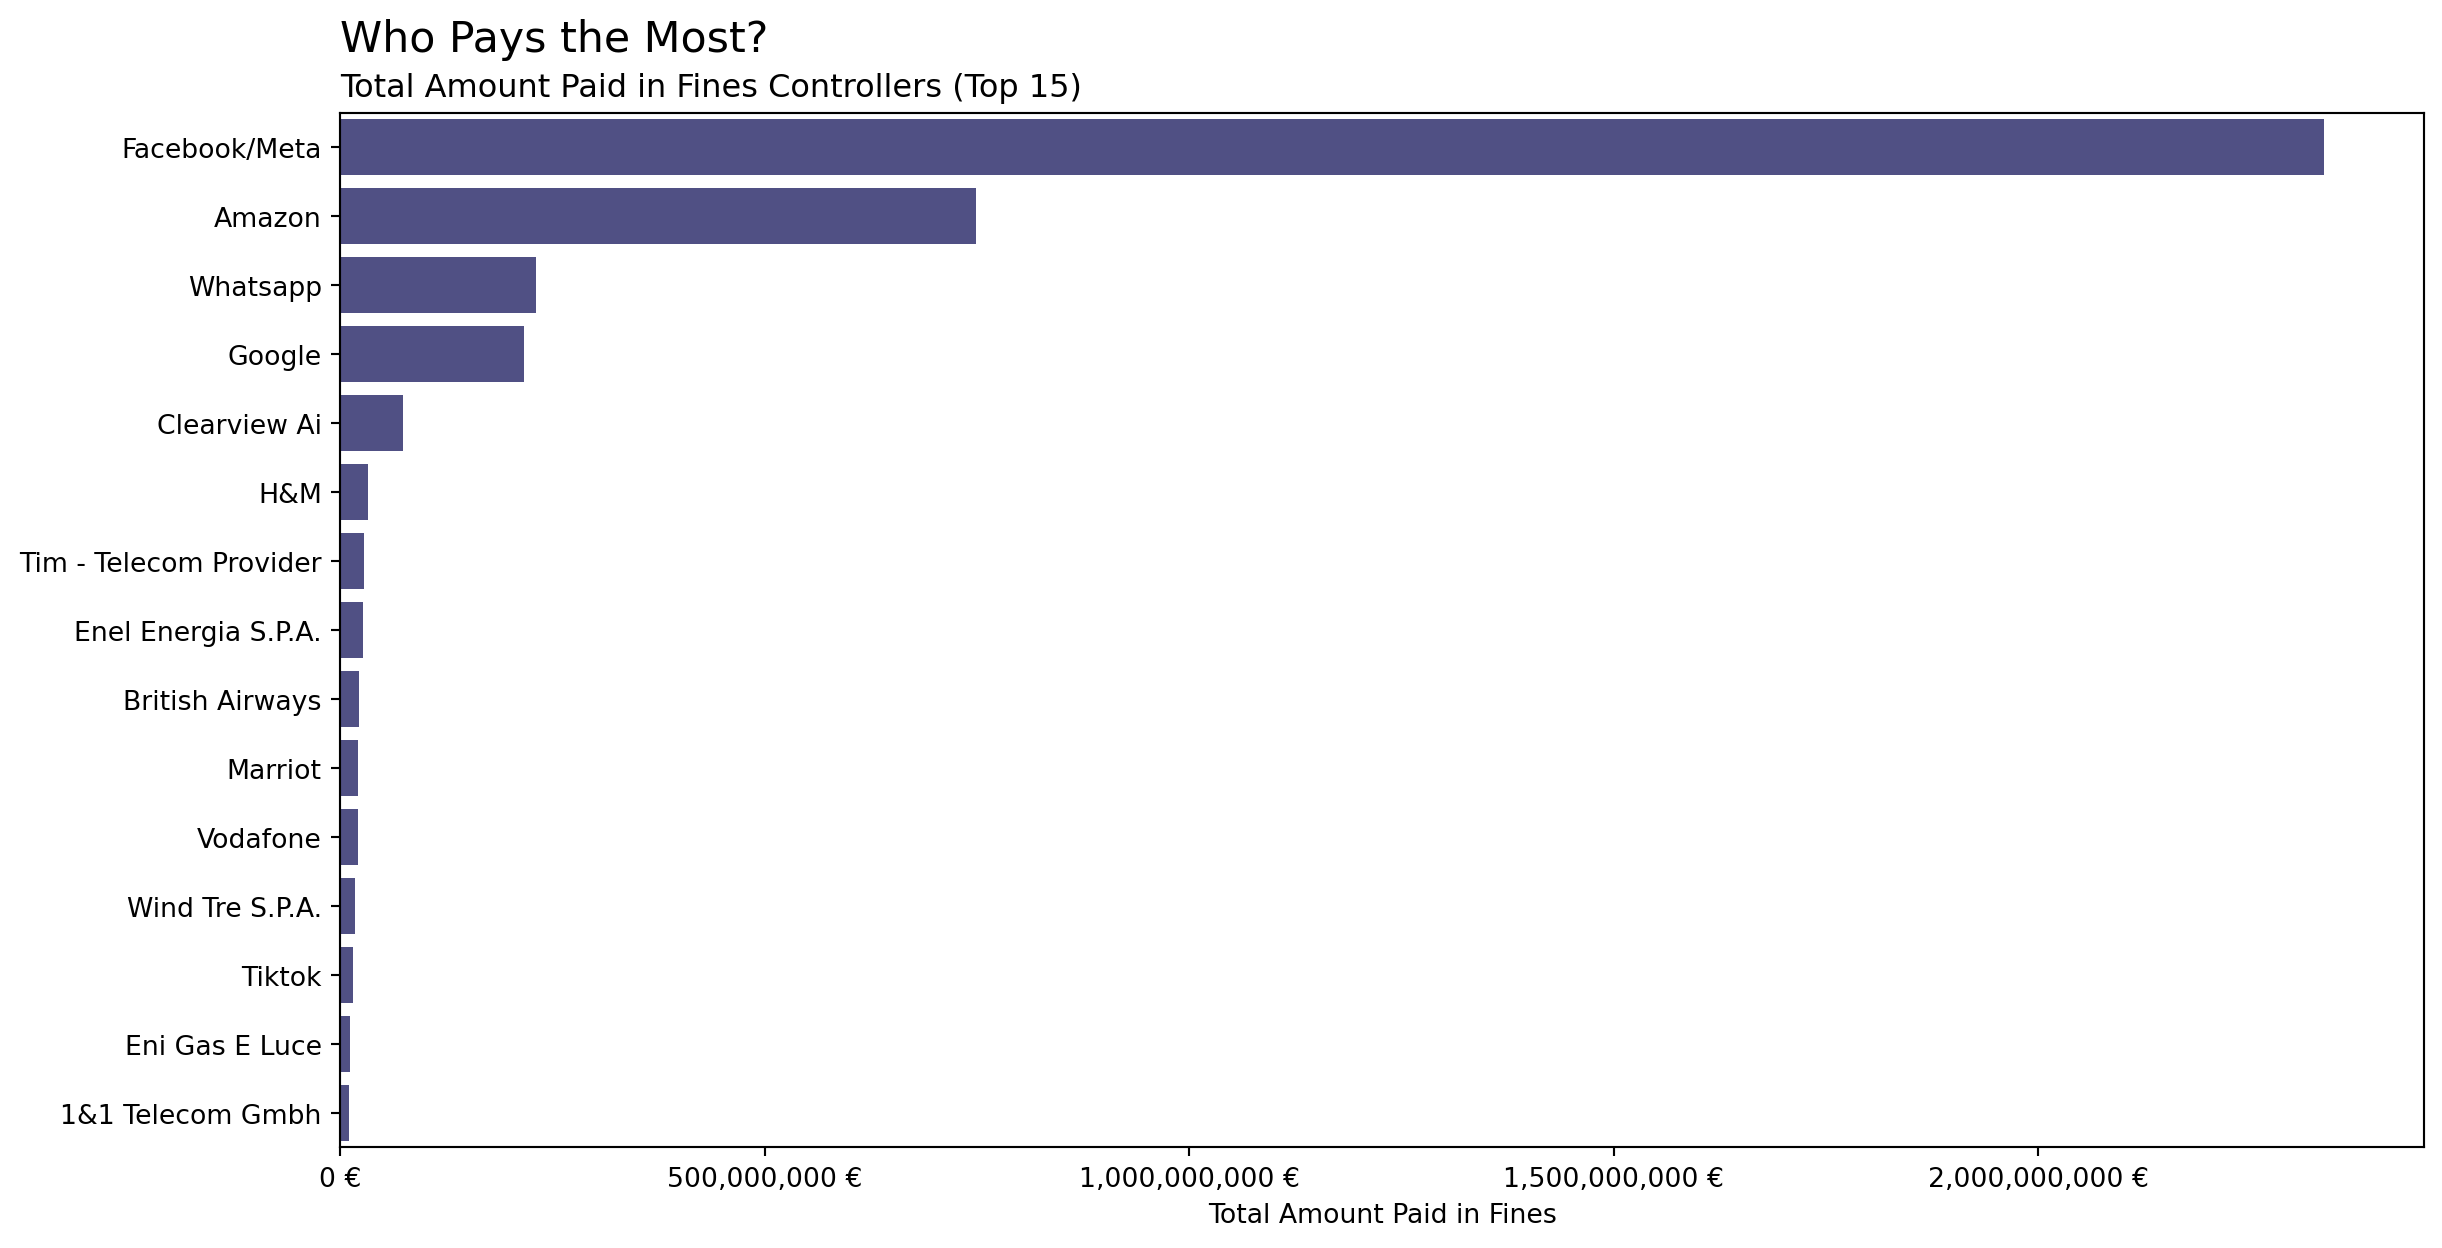

In [8]:
fig, ax = plt.subplots(figsize=(14, 7))

sns.barplot(y='shortname', x='total_price', data=controller_stats.nlargest(15, columns='total_price'),
            color='midnightblue', ax=ax, orient='h', alpha=0.8)

ax.set(xlabel="Total Amount Paid in Fines", ylabel=None)
ax.xaxis.set_major_formatter('{x:,.0f} €')
ax.set_title(label="Total Amount Paid in Fines Controllers (Top 15)", loc="left", ha="left", size=12)
fig.suptitle(t="Who Pays the Most?", x=ax.get_position().get_points()[0][0], ha='left', fontsize=16, y=0.95)

plt.show()

### Who Pays the Most Often?

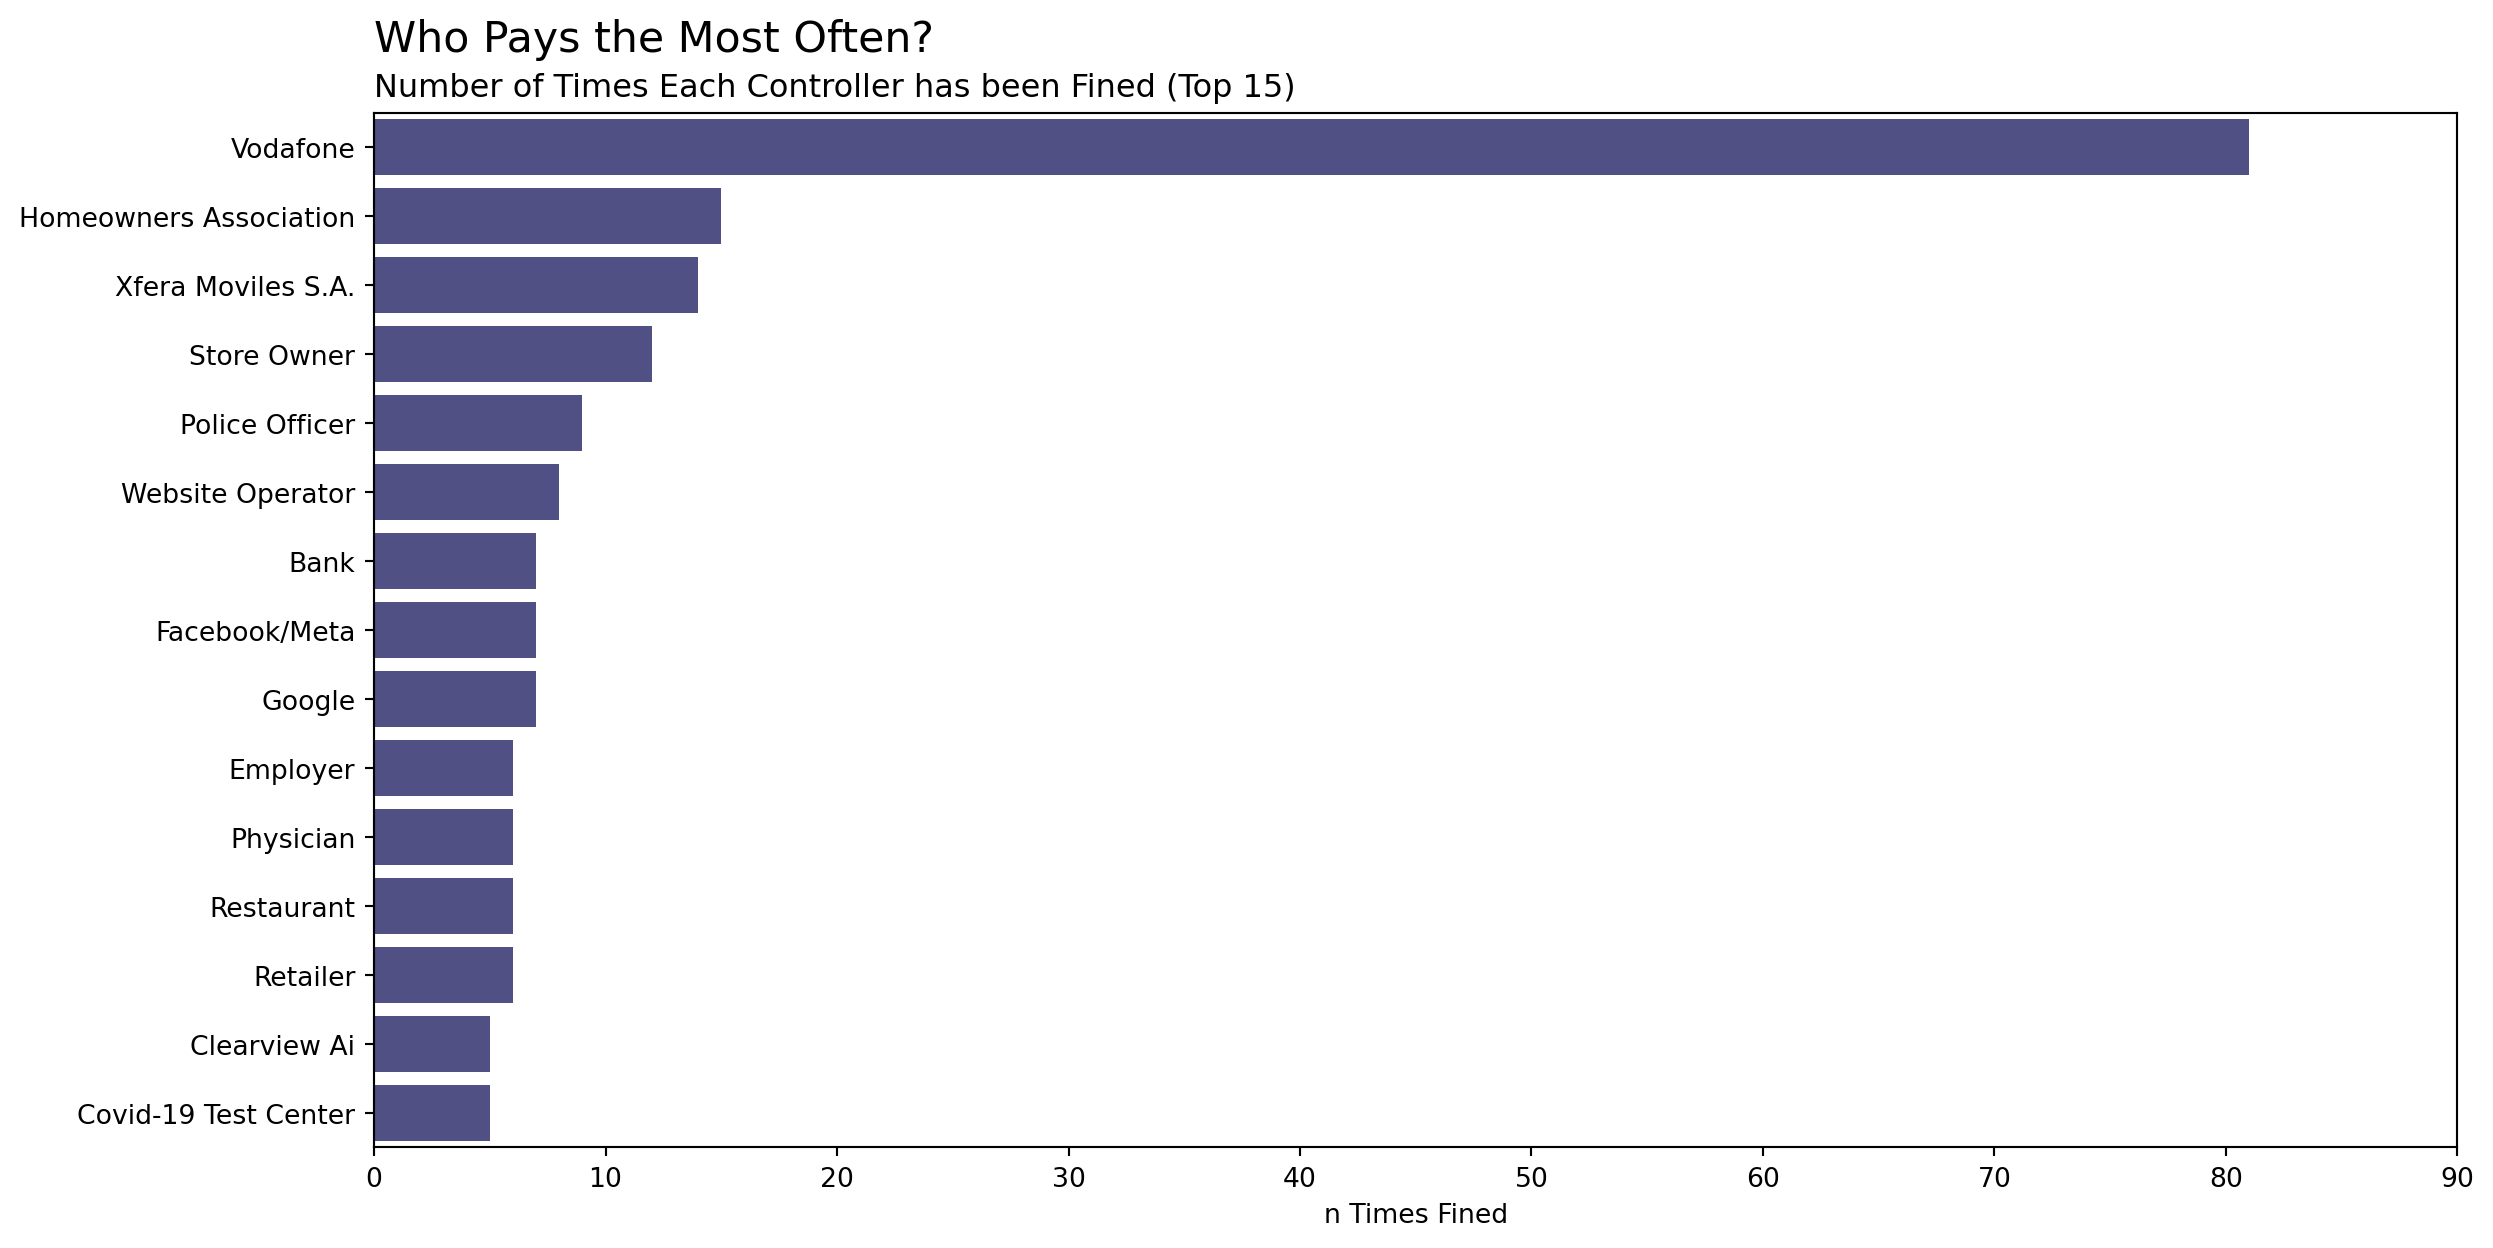

In [9]:
DONT_INCLUDE = ["Private Individual", "Unknown", "Company", "Unknown Company", "Not Available"]

fig, ax = plt.subplots(figsize=(14, 7))

sns.barplot(y='shortname', x='counts',
            data=controller_stats.query(f'~shortname.isin({DONT_INCLUDE})').nlargest(n=15, columns='counts'),
            color='midnightblue', ax=ax, orient='h', alpha=0.8)

ax.set(xlabel="n Times Fined", ylabel=None, xticks=range(0, controller_stats.counts.max(), 10))
ax.xaxis.set_major_formatter('{x:,.0f}')

# title and subtitle
ax.set_title(label="Number of Times Each Controller has been Fined (Top 15)", loc="left", ha="left", size=12)
fig.suptitle(t="Who Pays the Most Often?", x=ax.get_position().get_points()[0][0], ha='left', fontsize=16, y=0.95)

plt.show()

## Article References

At present the data is structured such that each row represents a single instance of an entity being fined in violation of one or more GDPR articles. It's possible for a single fine to be in reference to multiple articles being violated. To look at specific article violations (i.e. one row per article violation) the data will need to elongated.

In [10]:
fines_long = pivot_fines_longer(fines_nozero)

### Which articles are referenced the most often?

In [11]:
# df showing article next to how often it was referenced.
n_citations = (
    fines_long
    .value_counts('article_number')
    .reset_index(name='count')
    .sort_values('article_number')
)

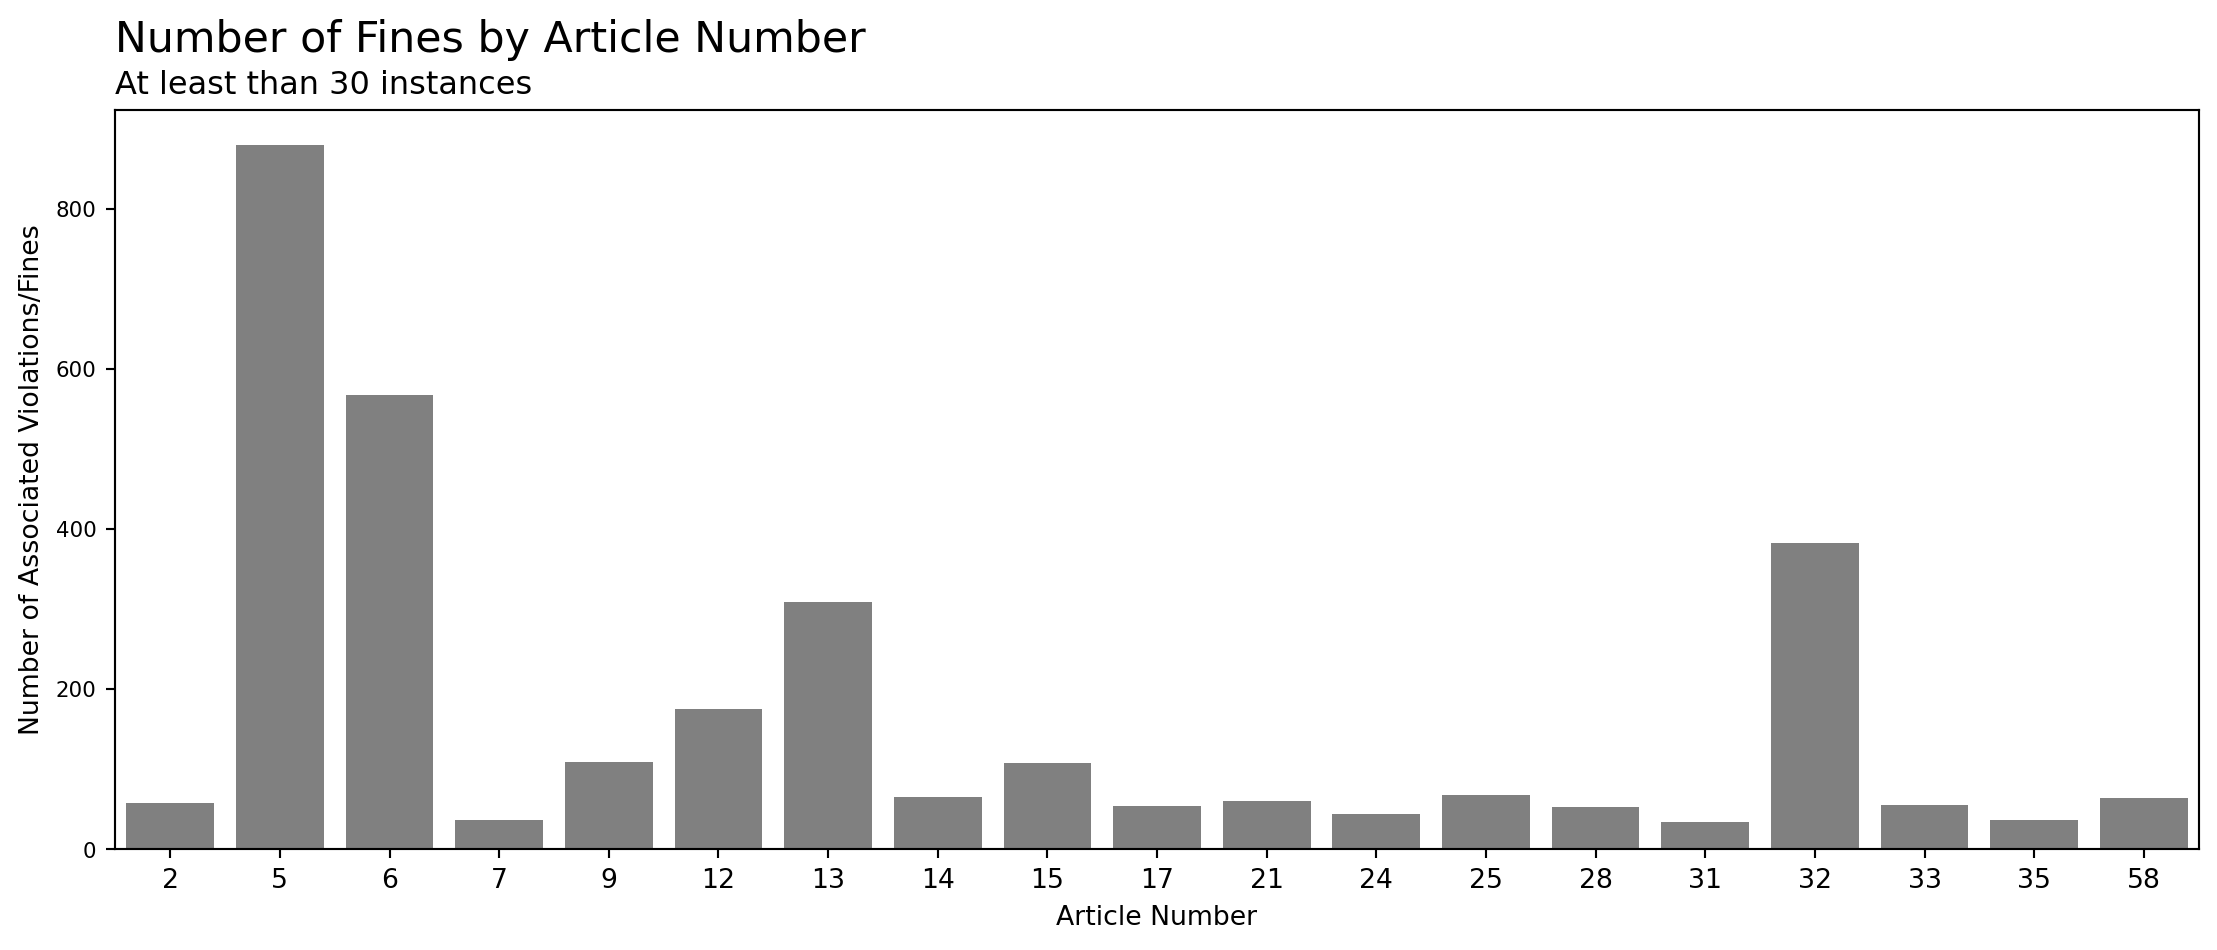

In [12]:
MIN_OCCURENCES = 30

fig, ax = plt.subplots(figsize = (14, 5))

sns.barplot(x='article_number', y='count', data=n_citations.query(f'count >= {MIN_OCCURENCES}'), orient='v', color='grey', ax=ax)
ax.tick_params(axis='y', which='major', labelsize=8)
ax.set(xlabel='Article Number', ylabel='Number of Associated Violations/Fines')

# title + subtitle
ax.set_title(f'At least than {MIN_OCCURENCES} instances', loc='left')
fig.suptitle('Number of Fines by Article Number', x=ax.get_position().get_points()[0][0], ha='left', fontsize=16, y=0.975)

plt.show()

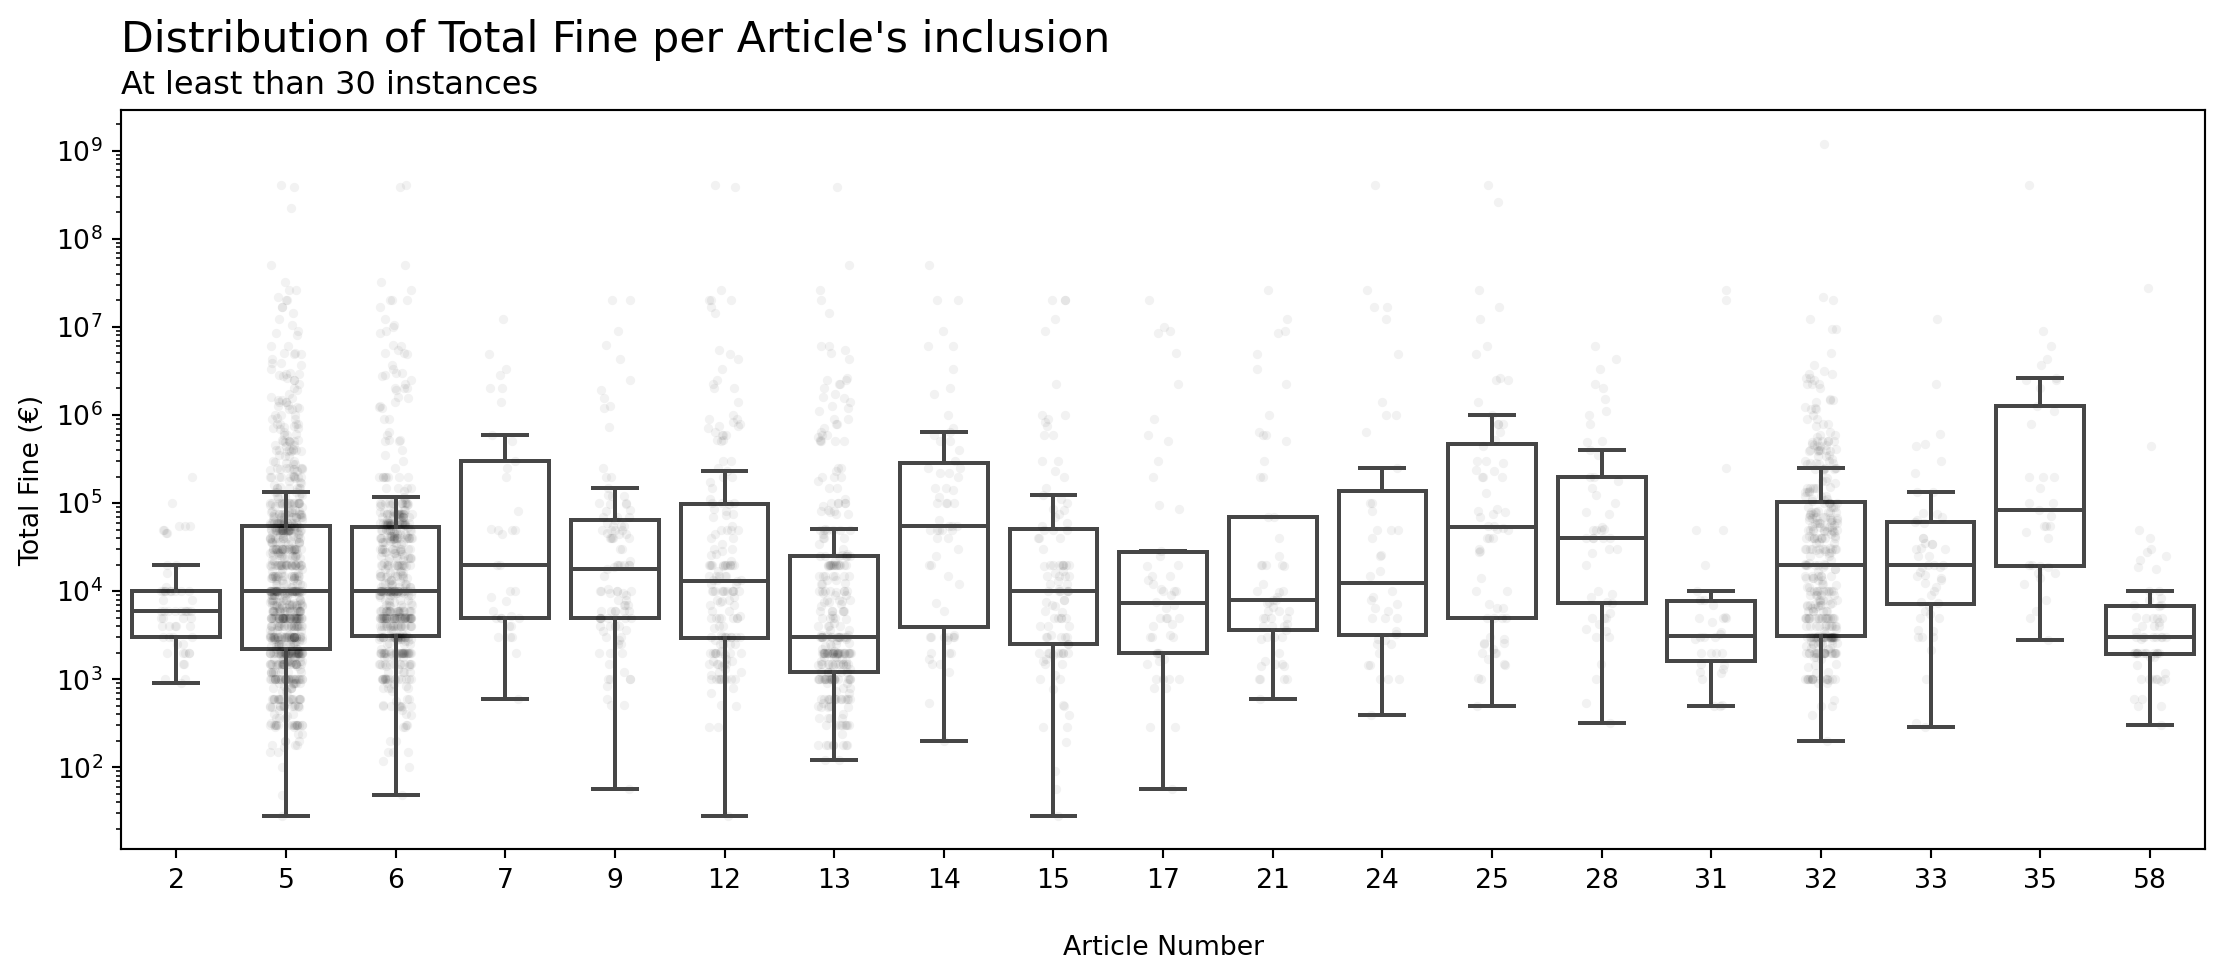

In [13]:
MIN_OCCURENCES = 30

df = n_citations.query(f'count >= {MIN_OCCURENCES}').merge(fines_long, how='inner', left_on='article_number', right_on='article_number')

fig, ax = plt.subplots(figsize=(14, 5))

sns.stripplot(
    x='article_number',
    y='total_fine_euro',
    data=df,
    color='black',
    jitter=0.15,
    size=3.5,
    alpha=0.05,
    ax=ax,
    zorder=1
)

sns.boxplot(
    x='article_number',
    y='total_fine_euro',
    data=df,
    ax=ax,
    showfliers=False,
    boxprops={'facecolor':'none'}
)

ax.set_yscale("log")
ax.set_title(label='', loc='left')
ax.set(xlabel="\nArticle Number", ylabel='Total Fine (€)')

# title + subtitle
ax.set_title(f'At least than {MIN_OCCURENCES} instances', loc='left')
fig.suptitle('Distribution of Total Fine per Article\'s inclusion', x=ax.get_position().get_points()[0][0], ha='left', fontsize=16, y=0.975);

In [14]:
df

,article_number,count,id,country,total_fine_euro,authority,date,controller,articleViolated,n_articles_violated,type,summary
0,2,58,781,Italy,200000,Italian Data Protection Authority (Garante),2021-09-16,Bocconi University,"Art. 5 (1) a), c), e) GDPR, Art. 6 GDPR, Art. ...",9,Non-compliance with lawful basis for data proc...,The Italian DPA (also known as Garante) has fi...
1,2,58,793,Italy,5000,Italian Data Protection Authority (Garante),2021-09-16,Comune di Montalbano Jonico,"Art. 5 (1) a), c) GDPR, Art. 6 (1) c), e) GDP...",7,Non-compliance with lawful basis for data proc...,The Italian DPA (also known as Garante) has fi...
2,2,58,793,Italy,5000,Italian Data Protection Authority (Garante),2021-09-16,Comune di Montalbano Jonico,"Art. 5 (1) a), c) GDPR, Art. 6 (1) c), e) GDP...",7,Non-compliance with lawful basis for data proc...,The Italian DPA (also known as Garante) has fi...
3,2,58,927,Italy,1000,Italian Data Protection Authority (Garante),2022-01-13,A.S.L. Napoli 1 Centro,"Art. 5 GDPR, Art. 6 GDPR, Art. 2-ter Codice de...",3,Non-compliance with lawful basis for data proc...,The Italian DPA (also known as Garante) has fi...
4,2,58,973,Italy,10000,Italian Data Protection Authority (Garante),2022-02-10,Region of Tuscany,"Art. 5 GDPR, Art. 6 GDPR, Art. 2-ter Codice de...",3,Failure to comply with data processing principles,The Italian DPA has fined the Region of Tuscan...
...,...,...,...,...,...,...,...,...,...,...,...,...
3157,58,64,1507,Poland,6800,Polish National Personal Data Protection Offic...,2022-08-30,TIMSHEL Sp. z o.o.,Art. 58 (1) e) GDPR,1,Insufficient cooperation with supervisory auth...,The Polish DPA (also known as UODO) has fined ...
3158,58,64,1508,Poland,960,Polish National Personal Data Protection Offic...,2022-01-01,Unknown,Art. 58 GDPR,1,Insufficient cooperation with supervisory auth...,The Polish DPA (also known as UODO) has fined ...
3159,58,64,1595,Spain,25000,Spanish Data Protection Authority (AEPD),2023-04-21,"SECURITAS DIREC ESPANA, S.A.",Art. 58 (2) GDPR,1,Non-cooperation with Data Protection Authority,The Spanish DPA has fined SECURITAS DIREC ESPA...
3160,58,64,1614,Spain,600,Spanish Data Protection Authority (AEPD),2022-07-19,Private individual,Art. 58 (2) GDPR,1,Non-cooperation with Data Protection Authority,The Spanish DPA (also known as AEPD) has fined...
